In [1]:
# + tags=[]
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import box, Point
import numpy as np
%matplotlib inline

## 1. AIS-Datenvorverarbeitung: Filterung, Δt-Berechnung & Cargo-Klassifikation

In [2]:
# ───────────────────────────────────────────────────────────────────────
# 1) CSV einlesen und erste Filterungen
# ───────────────────────────────────────────────────────────────────────
import pandas as pd

df = pd.read_csv(
    "data/processed/ais/ais_data_fehmarn_radius.csv",
    dtype={"MMSI": str},
    low_memory=False
)
print(f"📥  Ursprüngliche AIS-Meldungen geladen: {len(df):,}")

# Filter: nur Class A / B, „Under way using engine“, GPS-Positionen
initial_count = len(df)
df = df[df["Type of mobile"].isin(["Class A", "Class B"])]
print(f"🔹 Nach Mobile-Typ-Filter (Class A/B): {len(df):,} (entfernt {initial_count-len(df):,})")
before_nav = len(df)
df = df[df["Navigational status"] == "Under way using engine"]
print(f"🔹 Nach Navigational-Status-Filter: {len(df):,} (entfernt {before_nav-len(df):,})")
before_gps = len(df)
df = df[df["Type of position fixing device"] == "GPS"]
print(f"🔹 Nach Position-Fixing-Filter: {len(df):,} (entfernt {before_gps-len(df):,})\n")

# ───────────────────────────────────────────────────────────────────────
# 2) Timestamps sauber parsen & ungültige Zeilen verwerfen
# ───────────────────────────────────────────────────────────────────────
df["# Timestamp"] = pd.to_datetime(
    df["# Timestamp"],
    dayfirst=True,   # Format: Tag/Monat/Jahr
    errors="coerce"  # Ungültige → NaT
)
n0 = len(df)
df = df.dropna(subset=["# Timestamp"])
n1 = len(df)
print(f"🕒 Timestamp geparsed: {n0-n1:,} fehlerhafte Zeilen verworfen → {n1:,} verbleibend\n")

# ───────────────────────────────────────────────────────────────────────
# 3) Δt-Spalte berechnen (Sekunden)
# ───────────────────────────────────────────────────────────────────────
df = df.sort_values(["MMSI", "# Timestamp"]).reset_index(drop=True)
df["delta_t"] = (
    df.groupby("MMSI")["# Timestamp"]
      .diff()
      .dt.total_seconds()
      .fillna(0)
)
print(f"⏱ Δt (Zeitdifferenz) hinzugefügt für {len(df):,} Meldungen\n")

# ───────────────────────────────────────────────────────────────────────
# 4) Zielvariable: Cargo vs. Other
# ───────────────────────────────────────────────────────────────────────
df["is_cargo"] = (df["Ship type"] == "Cargo").astype(int)

counts = df["is_cargo"].value_counts().rename({1: "Cargo", 0: "Other"})
print("🚢 Klassenverteilung nach Filterung:")
for cls, cnt in counts.items():
    pct = cnt / len(df) * 100
    print(f"   • {cls:<5}: {cnt:,} ({pct:.1f} %)")
print()

# ───────────────────────────────────────────────────────────────────────
# 5) Stichprobe wichtiger Merkmale
# ───────────────────────────────────────────────────────────────────────
print("🔍 Stichprobe ausgewählter Features:")
display(
    df[["SOG", "COG", "Draught", "Width", "Length", "delta_t", "ROT", "is_cargo"]]
      .sample(10, random_state=42)
      .reset_index(drop=True)
)

📥  Ursprüngliche AIS-Meldungen geladen: 9,843,863
🔹 Nach Mobile-Typ-Filter (Class A/B): 9,742,712 (entfernt 101,151)
🔹 Nach Navigational-Status-Filter: 7,577,311 (entfernt 2,165,401)
🔹 Nach Position-Fixing-Filter: 6,395,761 (entfernt 1,181,550)

🕒 Timestamp geparsed: 0 fehlerhafte Zeilen verworfen → 6,395,761 verbleibend

⏱ Δt (Zeitdifferenz) hinzugefügt für 6,395,761 Meldungen

🚢 Klassenverteilung nach Filterung:
   • Other: 4,356,546 (68.1 %)
   • Cargo: 2,039,215 (31.9 %)

🔍 Stichprobe ausgewählter Features:


,SOG,COG,Draught,Width,Length,delta_t,ROT,is_cargo
0,0.0,113.3,5.0,26.0,142.0,10.0,0.0,0
1,15.7,13.3,5.0,26.0,142.0,5.0,1.1,0
2,8.5,283.9,4.0,12.0,81.0,11.0,0.0,1
3,0.2,204.5,1.9,8.0,23.0,20.0,0.0,0
4,3.4,297.8,4.5,17.0,116.0,11.0,0.0,1
5,13.3,82.9,6.4,20.0,155.0,12.0,0.0,1
6,18.6,95.4,6.2,26.0,199.0,2.0,0.0,0
7,16.0,192.4,5.0,26.0,142.0,6.0,0.0,0
8,0.4,70.2,6.2,13.0,39.0,7.0,NaN,0
9,3.7,65.9,2.0,8.0,22.0,20.0,NaN,0


## 2. Fehlende Werte

In [3]:
# ───────────────────────────────────────────────────────────────────────
# 6) Fehlende Werte pro Feature analysieren
# ───────────────────────────────────────────────────────────────────────
cols = ["SOG", "COG", "Draught", "Width", "Length", "delta_t", "ROT"]
missing_count = df[cols].isna().sum()
missing_pct   = (missing_count / len(df) * 100).round(2)
missing_df = pd.DataFrame({
    "missing_count": missing_count,
    "missing_pct":   missing_pct
}).sort_values("missing_count", ascending=False)

print("❗ Fehlende Werte pro Feature:")
display(missing_df)
print(f"➟ Feature mit den meisten Fehlwerten: {missing_df.index[0]} ({missing_df.iloc[0,0]} NaNs / {missing_df.iloc[0,1]} %)\n")



❗ Fehlende Werte pro Feature:


,missing_count,missing_pct
ROT,921935,14.41
Draught,40664,0.64
COG,5580,0.09
SOG,2152,0.03
Width,1154,0.02
Length,1154,0.02
delta_t,0,0.00


➟ Feature mit den meisten Fehlwerten: ROT (921935 NaNs / 14.41 %)



In [4]:
# Fehlende Werte gruppiert nach Ship type ---
missing_by_type = df.groupby("Ship type")[cols] \
                    .apply(lambda x: x.isna().sum())

print("\nFehlende Werte pro Ship type und Feature:")
display(missing_by_type)



Fehlende Werte pro Ship type und Feature:


,SOG,COG,Draught,Width,Length,delta_t,ROT
Ship type,,,,,,,
Anti-pollution,0,2,0,0,0,0,0
Cargo,1592,1594,0,0,0,0,67732
Dredging,0,0,0,0,0,0,7923
Fishing,0,0,0,0,0,0,2829
HSC,147,147,0,0,0,0,189581
Law enforcement,0,0,1035,1035,1035,0,1834
Military,0,1,6884,0,0,0,20033
Other,199,199,0,119,119,0,291754
Passenger,0,377,32745,0,0,0,41401


In [5]:
# nur die Spalten, die du wirklich betrachten willst
cols = ["SOG", "COG", "Draught", "Width", "Length", "delta_t"]
print("Feature ROT wurde entfernt")

Feature ROT wurde entfernt


In [6]:
# ───────────────────────────────────────────────────────────────────────
# 7) Fehlende-Werte-Bereinigung: dropna auf den wichtigen Spalten
# ───────────────────────────────────────────────────────────────────────
n_before = len(df)
df_clean = df.dropna(subset=cols)
n_after  = len(df_clean)
removed   = n_before - n_after
print(f"🧹 Nach dropna: {n_after:,} Meldungen verbleibend ({removed:,} entfernt)\n")

# Anzahl verbleibender Schiffe
n_ships_before = df["MMSI"].nunique()
n_ships_after  = df_clean["MMSI"].nunique()
removed_ships =  n_ships_before - n_ships_after


print(f"🧹 Nach dropna: {n_ships_after:,} Schiffe verbleibend ({removed_ships:,} entfernt)\n")


🧹 Nach dropna: 6,349,765 Meldungen verbleibend (45,996 entfernt)

🧹 Nach dropna: 1,540 Schiffe verbleibend (12 entfernt)



## 2. Sequenzanalyse

⚓ Sequenzlängen pro MMSI (Top 10):


MMSI
211190000    375413
219000429    355503
235103408    283412
211188000    259628
219000431    257114
219472000    245271
219018788    200366
219016665    190275
219016577    187291
219028973    168398
Name: count, dtype: int64

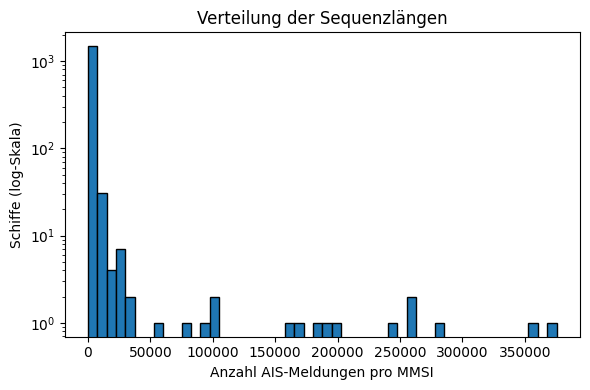

In [7]:
# ───────────────────────────────────────────────────────────────────────
# 8) Sequenzlängen pro Schiff untersuchen
# ───────────────────────────────────────────────────────────────────────
seq_lens = df_clean.groupby("MMSI").size().rename("count")
print("⚓ Sequenzlängen pro MMSI (Top 10):")
display(seq_lens.sort_values(ascending=False).head(10))

# Histogramm der Sequenzlängen
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
plt.hist(seq_lens, bins=50, log=True, edgecolor="black")
plt.xlabel("Anzahl AIS-Meldungen pro MMSI")
plt.ylabel("Schiffe (log-Skala)")
plt.title("Verteilung der Sequenzlängen")
plt.tight_layout()
plt.show()

In [8]:
# ───────────────────────────────────────────────────────────────────────
# 9) Schiffe mit zu kurzer Sequenz entfernen (<20 Meldungen)
# ───────────────────────────────────────────────────────────────────────
min_len = 100

valid_mmsi = seq_lens[seq_lens >= min_len].index
df_final   = df_clean[df_clean["MMSI"].isin(valid_mmsi)].copy()
print(f"✅ Nach Mindestlänge ≥{min_len}: {len(valid_mmsi):,} Schiffe verbleibend ({len(seq_lens)-len(valid_mmsi):,} entfernt)\n")


✅ Nach Mindestlänge ≥100: 1,527 Schiffe verbleibend (13 entfernt)



## 2. Sliding-Window-Sequenzen erzeugen

Wir übersetzen jede MMSI-Zeitreihe in eine Liste von Sequenzen der Form (L * Features)

In [9]:
from tqdm import tqdm

L = 20
features = cols
X, y = [], []

print("🔄 Erstelle Sequenzen (nicht-überlappend)…")
for mmsi, group in tqdm(df_final.groupby("MMSI"), 
                        desc="Schiffe", 
                        unit="Schiff"):
    g = group.sort_values("# Timestamp")
    label = int((g["is_cargo"] == 1).any())
    n = len(g)
    for start in range(0, n - L + 1, L):
        seq = g.iloc[start:start+L][features].values
        X.append(seq)
        y.append(label)
# erst hier ins Array wandeln
X = np.array(X)
y = np.array(y)
print(f"Fertig: X-Shape={X.shape}, y-Shape={y.shape}")

🔄 Erstelle Sequenzen (nicht-überlappend)…


Schiffe: 100%|██████████| 1527/1527 [00:31<00:00, 47.86Schiff/s] 

Fertig: X-Shape=(316729, 20, 6), y-Shape=(316729,)


## 3. Train/Test-Split & Feature-Scaling

Für RNN/TCN hilft es oft, die Features (z. B. SOG, COG, Draught) zu normalisieren.

In [10]:
from sklearn.model_selection import GroupShuffleSplit
from sklearn.preprocessing import StandardScaler
import numpy as np

# a) Split auf MMSI-Ebene
mmsis = df_final["MMSI"].unique()
gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, test_idx = next(gss.split(X, y, groups=np.repeat(mmsis, [len(df_final[df_final.MMSI==m])//L for m in mmsis])))
X_train, X_test = X[train_idx], X[test_idx]
y_train, y_test = y[train_idx], y[test_idx]

# b) Fit Scaler nur auf Training (flatten: alle Zeitpunkte)
scaler = StandardScaler()
X_train_flat = X_train.reshape(-1, X_train.shape[-1])
scaler.fit(X_train_flat)

# c) Transform
def scale_X(X):
    nseq,L,nf = X.shape
    Xf = X.reshape(-1, nf)
    Xf = scaler.transform(Xf)
    return Xf.reshape(nseq, L, nf)

X_train = scale_X(X_train)
X_test  = scale_X(X_test)

print("Shapes:", X_train.shape, X_test.shape, y_train.shape, y_test.shape)

Shapes: (248395, 20, 6) (68334, 20, 6) (248395,) (68334,)


In [10]:
from sklearn.model_selection import GroupShuffleSplit
from sklearn.preprocessing import StandardScaler
import numpy as np

# Sequenz-Länge
L = 20

# a) Split auf MMSI-Ebene
mmsis = df_final["MMSI"].unique()
# jede MMSI so oft wiederholen, wie sie Fenster erzeugt
seq_counts = [len(df_final[df_final.MMSI == m]) // L for m in mmsis]
groups     = np.repeat(mmsis, seq_counts)

gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, test_idx = next(
    gss.split(X, y, groups=groups)
)

# Sequenz-Split
X_train, X_test = X[train_idx], X[test_idx]
y_train, y_test = y[train_idx], y[test_idx]

# Wie viele einzigartige Schiffe pro Set?
train_mmsis = np.unique(groups[train_idx])
test_mmsis  = np.unique(groups[test_idx])

print(f"→ Sequenzen insgesamt: {len(X)}")
print(f"   → Training: {len(train_idx)} Sequenzen von {len(train_mmsis)} Schiffen")
print(f"   → Test:     {len(test_idx)} Sequenzen von {len(test_mmsis)} Schiffen")

# b) Fit Scaler nur auf Training (flatten: alle Zeitpunkte)
scaler = StandardScaler()
X_train_flat = X_train.reshape(-1, X_train.shape[-1])
scaler.fit(X_train_flat)

# c) Transform-Funktion
def scale_X(X):
    nseq, L, nf = X.shape
    Xf = X.reshape(-1, nf)
    Xf = scaler.transform(Xf)
    return Xf.reshape(nseq, L, nf)

X_train = scale_X(X_train)
X_test  = scale_X(X_test)

print("→ Nach Skalierung Shapes:", 
      f"X_train={X_train.shape}, X_test={X_test.shape},",
      f"y_train={y_train.shape}, y_test={y_test.shape}")

→ Sequenzen insgesamt: 316729
   → Training: 248395 Sequenzen von 1221 Schiffen
   → Test:     68334 Sequenzen von 306 Schiffen
→ Nach Skalierung Shapes: X_train=(248395, 20, 6), X_test=(68334, 20, 6), y_train=(248395,), y_test=(68334,)


## 4. Model Training

In [11]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset, random_split
from sklearn.metrics import roc_auc_score

# ─── 1) Hyper-Parameter ───────────────────────────────────────────────────────
L           = 20                         # Sequenz-Länge
n_features  = X_train.shape[2]           # Anzahl der Input-Features
batch_size  = 128
lr          = 1e-3
n_epochs    = 20
patience    = 3

# ─── 2) Dataset & DataLoader ─────────────────────────────────────────────────
# wir gehen davon aus, dass X_train, y_train, X_test, y_test bereits als NumPy-Arrays vorliegen
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Trainings-Dataset und Split für Validation
full_ds = TensorDataset(
    torch.tensor(X_train, dtype=torch.float32),
    torch.tensor(y_train, dtype=torch.float32),
)
n_val   = int(0.2 * len(full_ds))
n_train = len(full_ds) - n_val
train_ds, val_ds = random_split(full_ds, [n_train, n_val])


train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_ds,   batch_size=batch_size)
test_loader  = DataLoader(
    TensorDataset(torch.tensor(X_test, dtype=torch.float32),
                  torch.tensor(y_test, dtype=torch.float32)),
    batch_size=batch_size
)

In [12]:
# ─── 3) Modell definieren ────────────────────────────────────────────────────
class LSTMClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, dropout=0.3):
        super().__init__()
        self.mask_value = 0.0
        self.lstm = nn.LSTM(
            input_size=input_dim,
            hidden_size=hidden_dim,
            batch_first=True
        )
        self.dropout = nn.Dropout(dropout)
        self.out = nn.Linear(hidden_dim, 1)
    
    def forward(self, x):
        # Masking: setze alle mask_value-Einträge auf 0 
        # (PyTorch behandelt Padding besser über PackedSequence, hier aber simple Variante)
        x = torch.where(torch.isnan(x), torch.zeros_like(x), x)
        _, (h_n, _) = self.lstm(x)       # h_n: (1, batch, hidden_dim)
        h = h_n.squeeze(0)              # (batch, hidden_dim)
        h = self.dropout(h)
        logits = self.out(h)            # (batch, 1)
        return torch.sigmoid(logits).squeeze(1)

model = LSTMClassifier(n_features).to(device)

# ─── 4) Loss, Optimizer ───────────────────────────────────────────────────────
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# ─── 5) Early Stopping Setup ─────────────────────────────────────────────────
best_val_loss = float('inf')
epochs_no_improve = 0

In [13]:
# ─── 6) Training Loop ────────────────────────────────────────────────────────
for epoch in range(1, n_epochs+1):
    # -- Training --
    model.train()
    train_losses = []
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        preds = model(xb)
        loss  = criterion(preds, yb)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
    
    # -- Validation --
    model.eval()
    val_losses = []
    val_preds, val_targets = [], []
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            preds = model(xb)
            val_losses.append(criterion(preds, yb).item())
            val_preds.append(preds.cpu())
            val_targets.append(yb.cpu())
    val_loss = sum(val_losses) / len(val_losses)
    val_preds   = torch.cat(val_preds).numpy()    # floats in [0,1]
    val_targets = torch.cat(val_targets).numpy()  # ints 0/1

    # 1) AUC aus continuous scores
    val_auc = roc_auc_score(val_targets, val_preds)
    # 2) Accuracy aus gerundeten Wahrscheinlichkeiten
    val_hard = (val_preds >= 0.5).astype(int)
    val_acc  = (val_hard == val_targets).mean()

    print(
        f"Epoch {epoch}: "
        f"train_loss={sum(train_losses)/len(train_losses):.4f}  "
        f"val_loss={val_loss:.4f}  "
        f"val_auc={val_auc:.4f}  "
        f"val_acc={val_acc:.4f}"
    )
    
    # Early Stopping (weiterhin auf val_loss basierend)
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_no_improve = 0
        torch.save(model.state_dict(), "best_model.pt")
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print("→ Early stopping ausgelöst")
            break

Epoch 1: train_loss=0.2585  val_loss=0.2112  val_auc=0.9635  val_acc=0.9064
Epoch 2: train_loss=0.1998  val_loss=0.1834  val_auc=0.9706  val_acc=0.9277
Epoch 3: train_loss=0.1759  val_loss=0.1620  val_auc=0.9772  val_acc=0.9337
Epoch 4: train_loss=0.1551  val_loss=0.1355  val_auc=0.9850  val_acc=0.9457
Epoch 5: train_loss=0.1339  val_loss=0.1345  val_auc=0.9855  val_acc=0.9463
Epoch 6: train_loss=0.1209  val_loss=0.1118  val_auc=0.9902  val_acc=0.9543
Epoch 7: train_loss=0.1070  val_loss=0.0980  val_auc=0.9925  val_acc=0.9611
Epoch 8: train_loss=0.0973  val_loss=0.0925  val_auc=0.9936  val_acc=0.9628
Epoch 9: train_loss=0.0865  val_loss=0.0813  val_auc=0.9950  val_acc=0.9666
Epoch 10: train_loss=0.0807  val_loss=0.0758  val_auc=0.9955  val_acc=0.9705
Epoch 11: train_loss=0.0716  val_loss=0.0653  val_auc=0.9969  val_acc=0.9744
Epoch 12: train_loss=0.0680  val_loss=0.0718  val_auc=0.9960  val_acc=0.9706
Epoch 13: train_loss=0.0638  val_loss=0.0590  val_auc=0.9973  val_acc=0.9771
Epoch 14

In [14]:
# ─── 7) Evaluation auf Test-Set ──────────────────────────────────────────────
# Lade das beste Modell
model.load_state_dict(torch.load("best_model.pt"))
model.eval()

test_preds, test_targets = [], []
with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(device)
        preds = model(xb).cpu()
        test_preds.append(preds)
        test_targets.append(yb)

# Zu einem Array stapeln
test_preds   = torch.cat(test_preds).numpy()     # Wahrscheinlichkeiten in [0,1]
test_targets = torch.cat(test_targets).numpy().astype(int)  # 0 oder 1

# 1) Test‐Loss (BCELoss erwartet floats)
test_loss = criterion(
    torch.tensor(test_preds, dtype=torch.float32),
    torch.tensor(test_targets, dtype=torch.float32)
).item()

# 2) Accuracy über harte Vorhersagen
test_hard = (test_preds >= 0.5).astype(int)
test_acc  = (test_hard == test_targets).mean()

# 3) AUC über die Scores
test_auc  = roc_auc_score(test_targets, test_preds)

print(
    "\n--- Test‐Evaluation ---\n"
    f"Test Loss:    {test_loss:.4f}\n"
    f"Test Accuracy: {test_acc:.4f}\n"
    f"Test AUC:      {test_auc:.4f}"
)


--- Test‐Evaluation ---
Test Loss:    0.2588
Test Accuracy: 0.9326
Test AUC:      0.9787


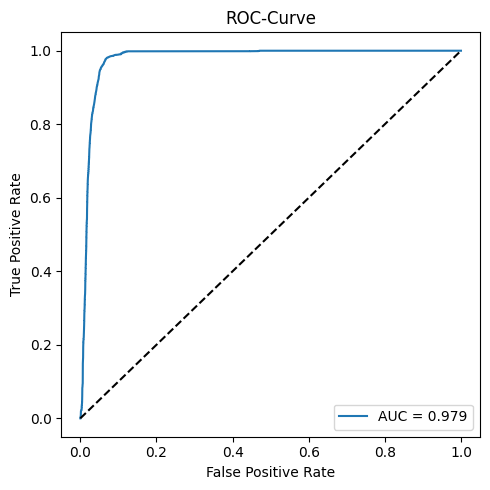

In [15]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(y_test, test_preds)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(5,5))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.3f}')
plt.plot([0,1],[0,1],'k--')
plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate')
plt.title('ROC-Curve'); plt.legend(loc='lower right'); plt.tight_layout()

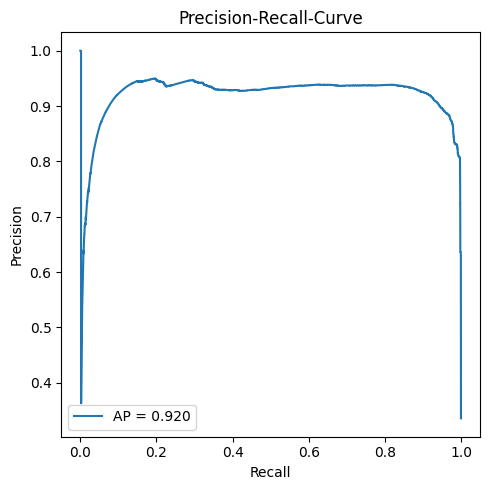

In [20]:
from sklearn.metrics import precision_recall_curve, average_precision_score

prec, recall, _ = precision_recall_curve(y_test, test_preds)
ap = average_precision_score(y_test, test_preds)

plt.figure(figsize=(5,5))
plt.plot(recall, prec, label=f'AP = {ap:.3f}')
plt.xlabel('Recall'); plt.ylabel('Precision')
plt.title('Precision-Recall-Curve'); plt.legend(loc='lower left'); plt.tight_layout()

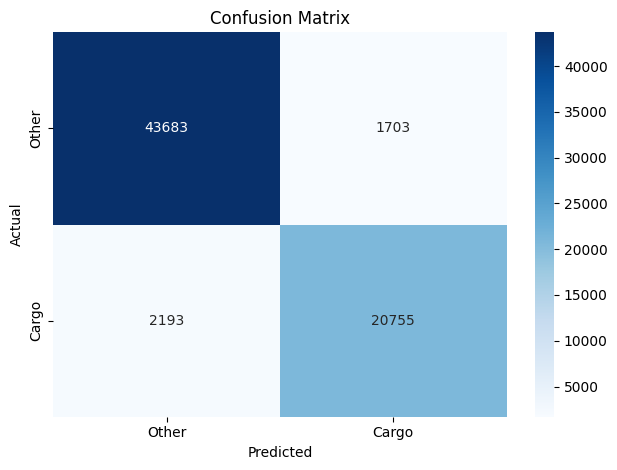

In [21]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(test_targets, test_hard)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Other','Cargo'], yticklabels=['Other','Cargo'])
plt.xlabel('Predicted'); plt.ylabel('Actual')
plt.title('Confusion Matrix'); plt.tight_layout()

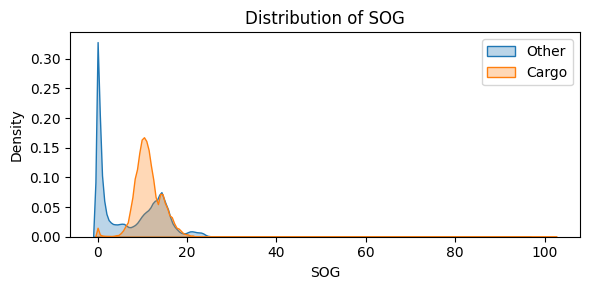

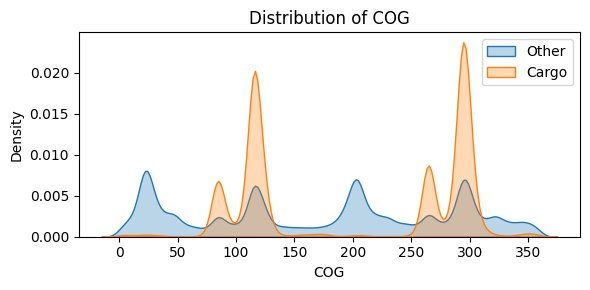

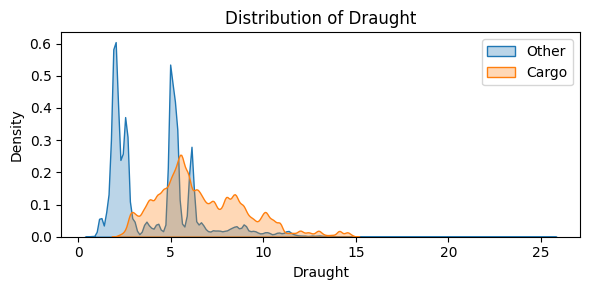

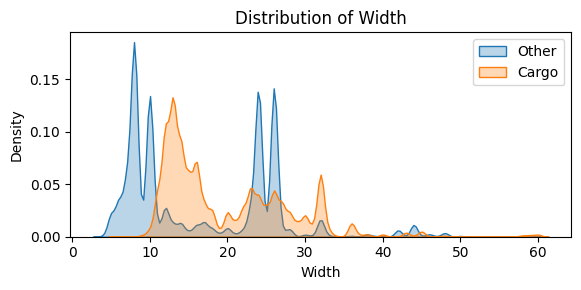

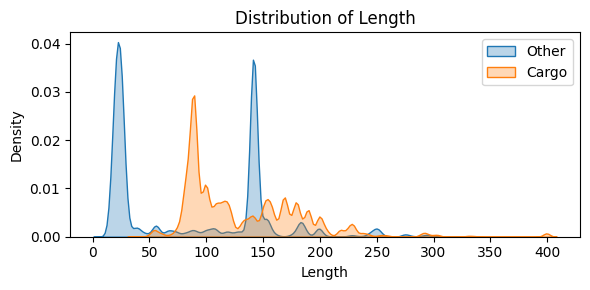

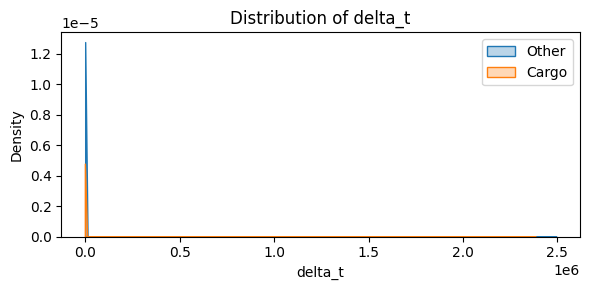

In [22]:
import seaborn as sns

for feat in ['SOG','COG','Draught','Width','Length','delta_t']:
    plt.figure(figsize=(6,3))
    sns.kdeplot(df_final.loc[df_final.is_cargo==0, feat], label='Other', fill=True, alpha=0.3)
    sns.kdeplot(df_final.loc[df_final.is_cargo==1, feat], label='Cargo', fill=True, alpha=0.3)
    plt.title(f'Distribution of {feat}')
    plt.xlabel(feat); plt.legend(); plt.tight_layout()